In [1]:
%pylab inline
#This is what %pylab does:
# import numpy
# import matplotlib
# from matplotlib import pylab, mlab, pyplot
# np = numpy
# plt = pyplot
# from IPython.core.pylabtools import figsize, getfigs
# from pylab import *
# from numpy import *
#import matplotlib.pyplot as plt

import os
import time
import glob
import numpy as np
import cupy as cp
import pandas as pd
from struct import *
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

import skimage
#print(skimage.__version__)
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

import dask
import dask.array as da
from dask.distributed import Client, progress, get_task_stream
from dask.diagnostics import ProgressBar

import mrcfile
import pickle
import webbrowser
from IPython.display import IFrame

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.append('/SIFT_gs/')
from SIFT_gs.FIBSEM_SIFT_gs import *

Open CV version:  3.4.1


In [14]:
def save_inlens_data(fname):
    tfr = FIBSEM_frame(fname)
    tfr.save_images('A')
    return fname

In [493]:
data_dir = 'D:/LID570_ROI4b'
data_dir = 'F:/Cryo_LoadID573_ROI4b'
fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))#[4100:4300]
nfrs = len(fls)
print('Total Number of frames to process: ', nfrs)

print('Step 2a: Creating "*InLens.tif" files using DASK distributed')
t00 = time.time()
futures = client.map(save_inlens_data, fls)
fls_new = np.array(client.gather(futures))
t01 = time.time()
print('Step 2a: Elapsed time: {:.2f} seconds'.format(t01 - t00))
print('Step 2a: Quick check if all files were converted: ', np.array_equal(fls, fls_new))

Total Number of frames to process:  17037
Step 2a: Creating "*InLens.tif" files using DASK distributed
Step 2a: Elapsed time: 6261.18 seconds
Step 2a: Quick check if all files were converted:  True


# This is where the data processing begins.

# Step 0: Set up the Processing Parameters. Check the data and evaluate the Threshold parameters.

Total Number of frames to process:  22
Encadala_C21
Transformation Matrix determined using RegularizedAffineTransform using RANSAC solver
[[ 1.00008990e+00  1.02408721e-04 -2.26819784e+00]
 [-3.59060453e-05  1.00033893e+00 -1.05484282e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
1665 keypoint matches were detected with 1.5 pixel outlier threshold
Number of iterations: 342
Registered data will be saved into:  Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc
Wall time: 19.1 s


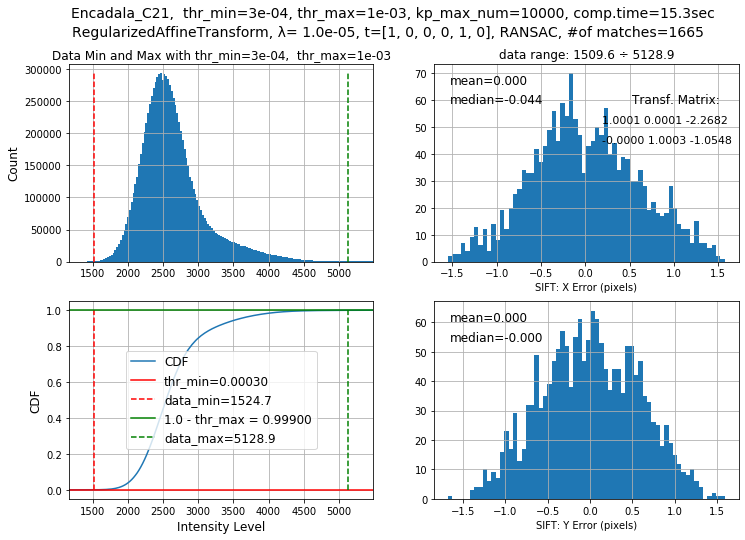

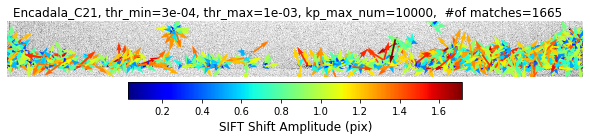

In [3]:
%%time

#data_dir = 'X:/instruments/fib-sem/Y2021/Kowalczyk/FIB-SEM/CryoLID543_ROI17/dats'
#data_dir = 'Z:/FIB-SEM SIFT align code/Test data'
#data_dir = 'Z:/FIB-SEM SIFT align code/Test data 2 from J10/'
#data_dir = 'F:/FIB-SEM_SIFT/LID556'
#data_dir = 'F:/LID570_ROI4a'
#data_dir = 'D:/LID570_ROI4b'
data_dir = 'F:/Cryo_LoadID573_ROI4b'
data_dir = 'F:/FIB-SEM_SIFT/subset'

use_DASK = True

threshold_min = 3e-4
threshold_max = 1e-3 # Make sure the number of matches in the prelim experiments above is between 150 and 350.
# in the number of matches is below 150 - increase threshold. If it is above 350 - decrease the threshold.
sliding_minmax = True

nbins = 256

BFMatcher = False   # If True, the BF Matcher is used for keypont matching
# otherwise FLANN Matcher (faster, preferable) is used.
matcher_str = 'BF' if BFMatcher else 'FLANN'

kp_max_num = 10000   # max number of key-points to be matched. Key-points in every frame are indexed (in descending order)
                    # by the strength of the response. Only kp_max_num is kept for further processing.
                    # Set this value to -1 if you want to keep ALL keypoints (may take forever to process!)

# Uncomment one from the below choices:
#SIFT_Transform = ShiftTransform                #  only x-shift and y-shift
#SIFT_Transform = XScaleShiftTransform          #  x-scale, x-shift, y-shift
#SIFT_Transform = ScaleShiftTransform           #  x-scale, y-scale, x-shift, y-shift
#SIFT_Transform = AffineTransform               #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)

SIFT_Transform = RegularizedAffineTransform     #  full Affine (x-scale, y-scale, rotation, shear, x-shift, y-shift)
                                                # with regularization on deviation from ShiftTransform
if SIFT_Transform == RegularizedAffineTransform:
    l2_param = 1e-5                                  # regularization strength (shrinkage parameter)
    l2_matrix = np.eye(6)*l2_param                   # initially set equal shrinkage on all coefficients
    l2_matrix[2,2]=0                                 # turn OFF the regularization on shifts
    l2_matrix[5,5]=0                                 # turn OFF the regularization on shifts
    targ_vector = np.array([1, 0, 0, 0, 1, 0])  # target transformation is shift only: Sxx=Syy=1, Sxy=Syx=0
    suffix = 'l2_{:.0e}'.format(l2_matrix[0,0])
else:
    l2_matrix= None
    targ_vector = None
    suffix = 'bilin'                  # optonal characters that will be added to the end of the filename (before the extension)

# String indicating which solver is to be used.
#solver = 'LinReg'   # 'LinReg' will use Linear Regression with iterative "Throwing out the Worst Residual" Heuristic
solver = 'RANSAC'   # 'RANSAC' will use RANSAC (Random Sample Consensus) algorithm.

drmax = 1.5           # dimensions - pixels.
                    #  - in the case of 'LinReg' - outlier threshold for iterative regression:
                    # For each matched pair of keypoins the error is calculated as err[j] = dst_pts[j] - A*src_pts[j]
                    # The iterative procedure throws away the matched keypoint pair with worst error on every iteration
                    # until the worst error falls below drmax or the max number of iterations is reached.
                    #
                    #  - in the case of 'RANSAC' - Maximum distance for a data point to be classified as an inlier.

max_iter = 1000  # max number of iterations in the iterative procedure above


save_asI8 = False            # If true, the data will be converted to I8 using global MIN and MAX values determined in the Step 1

preserve_scales = True       # If True, the transformation matrix will be adjusted using teh settings defined by fit_params below
fit_params = ['SG', 501, 3]  # perform the above adjustment using  Savitzky-Golay (SG) fith with parameters
                             # window size 701, polynomial order 3

#fit_params = ['LF']          # another option is to use linear fit with forces start points Sxx and Syy = 1 and Sxy and Syx = 0
#fit_params = ['PF', 2]      # another option is to use polynomial fit (in this case of order 2)


subtract_linear_fit = True   # If True, the linear slope will be subtracted from the cumulative shifts.
                             # This is performed after the optimal frame-to-frame shifts are recalculated for preserve_scales = True 

pad_edges = True             # If True, the edges will be padded with the amount equal to max shift excursion in each direction

zbin_2x = True               # If True, the data will be binned (averaged) x2 along z- (FIB-SEM milling) direction.

int_order = 1               #     The order of interpolation. The order has to be in the range 0-5:
                             #    - 0: Nearest-neighbor
                             #    - 1: Bi-linear (default)
                             #    - 2: Bi-quadratic
                             #    - 3: Bi-cubic
                             #    - 4: Bi-quartic
                             #    - 5: Bi-quintic


#********************************************************************************************************
# DO NOT MODIFY THE CODE BELOW!
#********************************************************************************************************

fls = sorted(glob.glob(os.path.join(data_dir,'*.dat')))#[4100:4300]
nfrs = len(fls)
print('Total Number of frames to process: ', nfrs)

if fit_params[1] > nfrs//2*2-1:  # if smoothing aperture (Sov-Gol) is larger than number of frames, reduce the aperture
    fit_params[1] = nfrs//2*2-1

frame0 = (os.path.join(data_dir,fls[0]))
Sample_ID = FIBSEM_frame(frame0).SampleID.strip('\x00')

save_image_png=True

dmin, dmax, comp_time, transform_matrix, n_matches, iteration, kpts = SIFT_evaluation(data_dir, [fls[nfrs//2], fls[nfrs//2+1]],
                                                                                threshold_min, threshold_max, nbins,
                                                                                SIFT_Transform, l2_matrix, targ_vector, solver, drmax, max_iter,
                                                                                kp_max_num, save_image_png)


src_pts_filtered, dst_pts_filtered = kpts

print('Transformation Matrix determined using '+ SIFT_Transform.__name__ +' using ' + solver + ' solver')
print(transform_matrix)
print('{:d} keypoint matches were detected with {:.1f} pixel outlier threshold'.format(n_matches, drmax))
print('Number of iterations: {:d}'.format(iteration))

fnm_reg, mrc_mode, dtp = build_filename(frame0, save_asI8, zbin_2x,
                                        SIFT_Transform, solver, drmax,
                                        preserve_scales, fit_params, subtract_linear_fit, pad_edges,
                                       suffix=suffix)
print('Registered data will be saved into: ', fnm_reg)

# Now Perform SIFT Computations using DASK Distributed (local cluster, using SCATTER, MAP and GATHER)

# Step 1: Set up Local DASK Client and Monitor Window

In [4]:
#start / restart client
try:
    client.restart()
except:
    client = Client()

In [5]:
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

Using Local Port:    8787


# Step 2a: Save InLens.tif Data (Optional)

In [18]:
print('Step 2a: Creating "*InLens.tif" files using DASK distributed')
t00 = time.time()
futures = client.map(save_inlens_data, fls)
fls_new = np.array(client.gather(futures))
t01 = time.time()
print('Step 2a: Elapsed time: {:.2f} seconds'.format(t01 - t00))
print('Step 2a: Quick check if all files were converted: ', np.array_equal(fls, fls_new))

Step 2a: Creating "*InLens.tif" files using DASK distributed
Step 2a: Elapsed time: 6.12 seconds
Step 2a: Quick check if all files were converted:  True


# Step 2: Calculate the Global Data Range

Step 2: Calculate the Global Data Range using DASK distributed
Step 2: Elapsed time: 5.38 seconds
Global Data Range for I8 conversion:  Min=1509.60, Max=7267.21


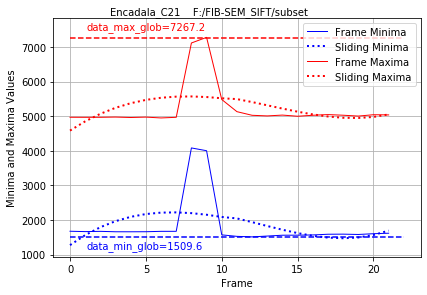

In [6]:
# Step 2: Calculate the Global Data Range using DASK Distributed

t0 = time.time()
params_s2 = [[fl, threshold_min, threshold_max, nbins] for fl in fls]

if use_DASK:
    print('Step 2: Calculate the Global Data Range using DASK distributed')
    futures = client.map(get_min_max_thresholds_file, params_s2)
    data_minmax_glob = np.array(client.gather(futures))
else:
    print('Step 2: Calculate the Global Data Range using local comutation')
    data_minmax_glob = np.zeros((nfrs, 2))
    for j, param_s2 in enumerate(tqdm(params_s2, desc='Calculating the Global Data Range: ')):
        data_minmax_glob[j, :] = get_min_max_thresholds_file(param_s2)

#data_min_glob = np.min(data_minmax_glob)
#data_max_glob = np.max(data_minmax_glob)
data_min_glob, trash = get_min_max_thresholds(data_minmax_glob[:, 0], threshold_min, threshold_max, nbins) 
trash, data_max_glob = get_min_max_thresholds(data_minmax_glob[:, 1], threshold_min, threshold_max, nbins)

data_min_sliding = savgol_filter(data_minmax_glob[:, 0].astype(double), min([fit_params[1], fit_params[1]]), fit_params[2])
data_max_sliding = savgol_filter(data_minmax_glob[:, 1].astype(double), min([fit_params[1], fit_params[1]]), fit_params[2])

# if needed, change the global data range
#data_min_glob = -4300
#data_max_glob = -1500

t1 = time.time()
print('Step 2: Elapsed time: {:.2f} seconds'.format(t1 - t0))
print('Global Data Range for I8 conversion:  Min={:.2f}, Max={:.2f}'.format(data_min_glob, data_max_glob))

fs = 12
fig0, ax0 = subplots(1,1,figsize=(6,4))
fig0.subplots_adjust(left=0.14, bottom=0.11, right=0.99, top=0.94)
ax0.plot(data_minmax_glob[:, 0], 'b', linewidth=1, label='Frame Minima')
ax0.plot(data_min_sliding, 'b', linewidth=2, linestyle = 'dotted', label='Sliding Minima')
ax0.plot(data_minmax_glob[:, 1], 'r', linewidth=1, label='Frame Maxima')
ax0.plot(data_max_sliding, 'r', linewidth=2, linestyle = 'dotted', label='Sliding Maxima')
ax0.legend()
ax0.grid(True)
ax0.set_xlabel('Frame')
ax0.set_ylabel('Minima and Maxima Values')
dxn = (data_max_glob - data_min_glob)*0.1
ax0.set_ylim((data_min_glob - dxn, data_max_glob+dxn))
# if needed, display the data in a narrower range
#ax0.set_ylim((-4500, -1500))
xminmax = [0, len(data_minmax_glob)]
y_min = [data_min_glob, data_min_glob]
y_max = [data_max_glob, data_max_glob]
ax0.plot(xminmax, y_min, 'b', linestyle = '--')
ax0.plot(xminmax, y_max, 'r', linestyle = '--')
ax0.text(len(data_minmax_glob)/20.0, data_min_glob-dxn/1.75, 'data_min_glob={:.1f}'.format(data_min_glob), fontsize = fs-2, c='b')
ax0.text(len(data_minmax_glob)/20.0, data_max_glob+dxn/2.25, 'data_max_glob={:.1f}'.format(data_max_glob), fontsize = fs-2, c='r')
ldm = 50
data_dir_short = data_dir if len(data_dir)<ldm else '... '+ data_dir[-ldm:]  
fig0.suptitle(Sample_ID + '    ' +  data_dir_short, fontsize = fs-2)
fig0.savefig(os.path.join(data_dir, fnm_reg.replace('.mrc','_DataBounds.png')), dpi=300)

In [11]:
use_DASK = False

# Steps 3 and 4: Extract Key Points and Descriptors, Find Matches and Transformations

Step 3: Extract Key Points and Descriptors using local comutation


Extracting Key Points and Descriptors:   0%|          | 0/22 [00:00<?, ?it/s]

Step 3: Elapsed time: 45.58 seconds
Step 4: Select Good Matches with FLANN matcher
Step 4: using RegularizedAffineTransform Transformation Model with RANSAC solver
Step 4: and extracting transformation parameters using local computation
Step 4: RegularizedAffineTransform parameters:
Step 4: Regularization matrix: 
[[1.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
Step 4: Target Solution:  [1 0 0 0 1 0]


Extracting Transformation Parameters:   0%|          | 0/21 [00:00<?, ?it/s]

Step 4: Elapsed time: 250.03 seconds
Mean Number of Keypoints : 1357


Calculating Original Cummilative Transformation Matrix:   0%|          | 0/21 [00:00<?, ?it/s]

Recalculating the transformation matrix for preserved scales


Recalculating the shifts for preserved scales:   0%|          | 0/21 [00:00<?, ?it/s]

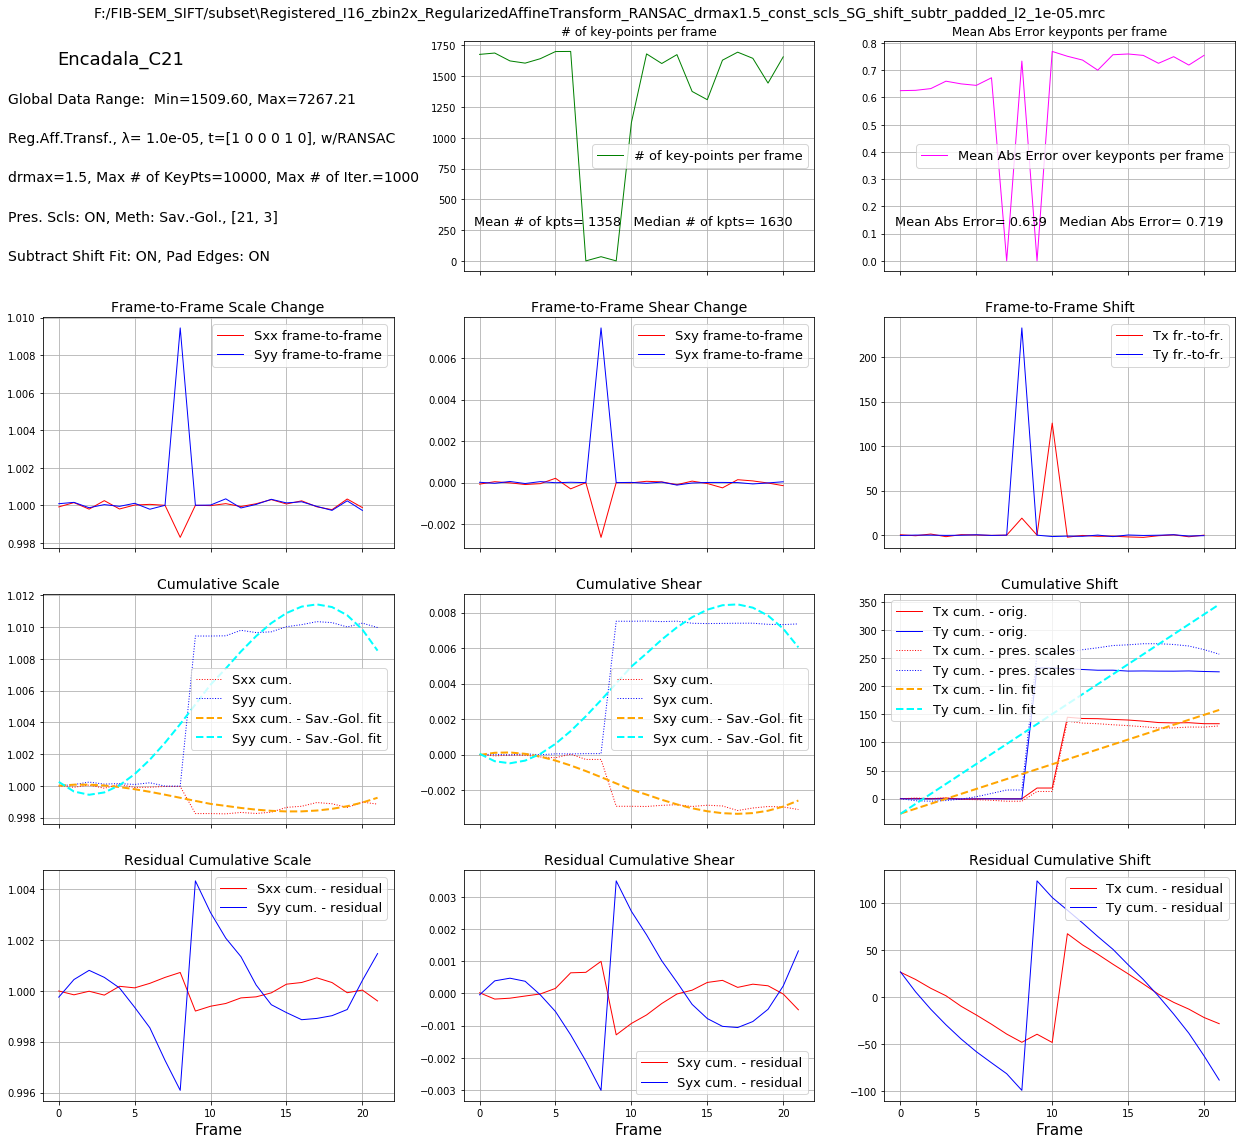

In [13]:
# Step 3: Extract Key Points and Descriptors using DASK Distributed
t1 = time.time()
if sliding_minmax:
    params_s3 = [[dts3[0], dts3[1], dts3[2], kp_max_num] for dts3 in zip(fls, data_min_sliding, data_max_sliding)]
else:
    params_s3 = [[fl, data_min_glob, data_max_glob, kp_max_num] for fl in fls]
        
if use_DASK:
    print('Step 3: Extract Key Points and Descriptors using DASK distributed')
    futures_s3 = client.map(extract_keypoints_descr_files, params_s3)
    fnms = client.gather(futures_s3)
else:
    print('Step 3: Extract Key Points and Descriptors using local comutation')
    fnms = []
    for j, param_s3 in enumerate(tqdm(params_s3, desc='Extracting Key Points and Descriptors: ')):
        fnms.append(extract_keypoints_descr_files(param_s3))
    
t2 = time.time()
print('Step 3: Elapsed time: {:.2f} seconds'.format(t2 - t1))

# Step 4: Select good matches and extract transformation parameters using DASK Distributed
print('Step 4: Select Good Matches with ' + matcher_str + ' matcher')
print('Step 4: using ' + SIFT_Transform.__name__ + ' Transformation Model with ' + solver + ' solver')
if use_DASK:
    print('Step 4: and extracting transformation parameters using DASK distributed')
else:
    print('Step 4: and extracting transformation parameters using local computation')
if SIFT_Transform == RegularizedAffineTransform:
    print('Step 4: ' + SIFT_Transform.__name__ + ' parameters:')
    print('Step 4: Regularization matrix: ')
    print(l2_matrix)
    print('Step 4: Target Solution: ', targ_vector)
params_s4 = []
save_matches = True
for j, fnm in enumerate(fnms[:-1]):
    fname1 = fnms[j]
    fname2 = fnms[j+1]
    params_s4.append([fname1, fname2, SIFT_Transform, l2_matrix, targ_vector, BFMatcher, solver, drmax, max_iter, save_matches])

if use_DASK:
    futures4 = client.map(determine_transformations_files, params_s4)
    #determine_transformations_files returns (transform_matrix, fnm_matches, kpts, iteration)
    results_dask_distributed = client.gather(futures4)
else:
    results_dask_distributed = []
    for param_s4 in tqdm(params_s4, desc = 'Extracting Transformation Parameters: '):
        results_dask_distributed.append(determine_transformations_files(param_s4))
t3 = time.time()
print('Step 4: Elapsed time: {:.2f} seconds'.format(t3 - t2))

#determine_transformations_files returns (transform_matrix, fnm_matches, kpts, errors, iteration)

transformation_matrix = np.nan_to_num(np.array([result[0] for result in results_dask_distributed]))
fnms_matches = [result[1] for result in results_dask_distributed]
error_abs_mean = np.nan_to_num(np.array([result[3] for result in results_dask_distributed]))
npts = np.nan_to_num(np.array([len(result[2][0])  for result in results_dask_distributed]))
print('Mean Number of Keypoints :', np.mean(npts).astype(np.int16))

tr_matr_cum_residual = process_transf_matrix(transformation_matrix, fnms_matches, npts, error_abs_mean, Sample_ID, data_min_glob, data_max_glob,
                          SIFT_Transform, l2_matrix, targ_vector, solver, kp_max_num, drmax, max_iter, preserve_scales, fit_params, subtract_linear_fit, pad_edges,
                          data_dir, fnm_reg, save_plot=True, add_suff = '')

# Step 5: Search for frames with no (or low # of) matches and possibly remove them.

In [10]:
thr_npt = 3   # consider frame with less than 3 Key Points for removal
inds_zeros = np.squeeze(np.argwhere(np.array(npts) < thr_npt ))
print('Frames with no matches to the next frame:  ', np.array(inds_zeros))
for j in inds_zeros:
    print('Frame: {:d}'.format(j) + ', File: ' + fls[j])
frames_to_remove = []
for ind0 in inds_zeros:
    if ind0 < (len(fls)-2) and npts[ind0+1] < thr_npt:
        frames_to_remove.append(ind0+1)
        print('Frame to remove: {:d} : '.format(ind0+1))
        print(fls[ind0+1])
        frame_to_remove  = FIBSEM_frame(os.path.join(data_dir,fls[ind0+1]))
        frame_to_remove.save_snapshot(dpi=300)
    
print('Frames to remove:  ', frames_to_remove)

if len(frames_to_remove) == 0:
    print('No frames selected for removal, proceeeding toi the next step')
else:
    # create copies of the original arrays
    fnms_orig = fnms.copy()
    fls_orig = fls.copy()
    error_abs_mean_orig = error_abs_mean.copy()
    tr_matrix_orig = transformation_matrix.copy()

    # go through the frames to be removed and remove the frames from the list and then re-calculate the shift for new neighbours.
    for j,fr in enumerate(tqdm(frames_to_remove, desc = 'Removing frames and finding shifts for new sequential frames')):
        frj = fr-j # to account for the fact that every time we remove a frame the array shrinks and indicis reset
        print('Removing the frame {:d}'.format(frj))
        print(fls[frj])
        fls = np.delete(fls, frj)
        fnms = np.delete(fnms, frj)
        fnms_matches = np.delete(fnms_matches, frj)
        error_abs_mean = np.delete(error_abs_mean, frj)
        transformation_matrix = np.delete(transformation_matrix, frj, axis = 0)
        npts = np.delete(npts, frj, axis = 0)
        fname1 = fnms[frj-1]
        fname2 = fnms[frj]
        new_step4_res = determine_transformations_files([fname1, fname2, SIFT_Transform, l2_matrix, targ_vector, BFMatcher, solver, drmax, max_iter, save_matches])
        npts[frj-1] = np.array(len(new_step4_res[2][0]))
        error_abs_mean[frj-1] = new_step4_res[3]
        transformation_matrix[frj-1] = np.array(new_step4_res[0])
    print('Mean Number of Keypoints :', np.mean(npts).astype(int))

    tr_matr_cum_residual = process_transf_matrix(transformation_matrix, fnms_matches, npts, error_abs_mean, Sample_ID, data_min_glob, data_max_glob,
                          SIFT_Transform, l2_matrix, targ_vector, solver, kp_max_num, drmax, max_iter, preserve_scales, fit_params, subtract_linear_fit, pad_edges,
                          data_dir, fnm_reg, save_plot=True, add_suff = '')

Frames with no matches to the next frame:   [7 9]
Frame: 7, File: F:/FIB-SEM_SIFT/subset\Gemini450-0113_22-03-07_003549_0-0-0.dat
Frame: 9, File: F:/FIB-SEM_SIFT/subset\Gemini450-0113_22-03-14_120636_0-0-0.dat
Frames to remove:   []
No frames selected for removal, proceeeding toi the next step


# Step 6: Recall or Save the Intermediate Data (KeyPoints, Matches, Transf.Matrix, etc.) from / into spreadsheets and a binary files.  Remove the intermediate KeyPoint/Descriptor files.

In [13]:
recall_the_data = False          # if False, the data will be saved. if True, the data will be recalled

remove_key_points_data = True   # if True, the binary files with intermediate keypoints data for each frame will be removed

'''
# Save and recall the transformation_matrix and keypoint statistics using binary files
# Save the X-Y shift data and keypoint statistics into a binary file
shifts_fnm = os.path.join(data_dir, 'XYshifts_kpt_data.bin')
pickle.dump([shifts_dask_distributed, npts_dask_distributed], open(shifts_fnm, 'wb'))
# Recall the X-Y shift data and keypoint statistics from a binary file
shifts_data, npts_data = pickle.load(open(shifts_fnm, 'rb'))
'''

npts_fnm = os.path.join(data_dir, fnm_reg).replace('.mrc', '_Npts_Errs_data.csv')
Tr_matrix_xls_fnm = os.path.join(data_dir, fnm_reg).replace('.mrc', '_Transform_Matrix_data.csv')
param_dump_fnm = os.path.join(data_dir, fnm_reg).replace('.mrc', '_params.bin')

if recall_the_data: # Recall the data
    npdt_recalled = pd.read_csv(npts_fnm)
    tr_mx_recalled = pd.read_csv(Tr_matrix_xls_fnm)
    transformation_matrix = (tr_mx_recalled.to_numpy()).reshape((len(tr_mx_recalled), 3, 3))
    all_params = pickle.load(open(param_dump_fnm, 'rb'))
    [transformation_matrix, tr_matr_cum_residual, fnms_matches, npts, error_abs_mean, Sample_ID, threshold_min, threshold_min, data_min_glob, data_max_glob,
     SIFT_Transform, l2_matrix, targ_vector, solver, kp_max_num, drmax, max_iter, preserve_scales, fit_params, l2_matrix, targ_vector, subtract_linear_fit, pad_edges, zbin_2x,
     int_order, suffix, data_dir, fnm_reg] = all_params
    display(tr_mx_recalled.head(), npdt_recalled.head())
    
    
else:  # or Save teh data
    all_params = [transformation_matrix, tr_matr_cum_residual, fnms_matches, npts, error_abs_mean, Sample_ID, threshold_min, threshold_min, data_min_glob, data_max_glob,
                  SIFT_Transform, l2_matrix, targ_vector, solver, kp_max_num, drmax, max_iter, preserve_scales, fit_params, l2_matrix, targ_vector, subtract_linear_fit, pad_edges, zbin_2x,
                  int_order, suffix, data_dir, fnm_reg]
    pickle.dump(all_params, open(param_dump_fnm, 'wb'))

    # Save and recall the shifts and keypoint statistics using excell spreadsheet
    
    # Save the keypoint statistics into a CSV file
    columns=['Npts', 'Mean Abs Error']
    npdt = pd.DataFrame(np.vstack((npts, error_abs_mean)).T, columns = columns, index = None)
    npdt.to_csv(npts_fnm, index = None)

    
    # Save the X-Y shift data and keypoint statistics into a CSV file
    columns=['T00 (Sxx)', 'T01 (Sxy)', 'T02 (Tx)',  
             'T10 (Syx)', 'T11 (Syy)', 'T12 (Ty)', 
             'T20 (0.0)', 'T21 (0.0)', 'T22 (1.0)']
    tr_mx_dt = pd.DataFrame(transformation_matrix.reshape((len(transformation_matrix), 9)), columns = columns, index = None)
    tr_mx_dt.to_csv(Tr_matrix_xls_fnm, index = None)

# Remove temporary files
if remove_key_points_data:
    # Remove the keypoint/ descriptor files
    for fnm in tqdm(fnms, desc='Removing KeyPoint/Descriptor Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass
    for fnm in tqdm(fnms_matches, desc='Removing Matched KeyPoint Files: '):
        try:
            os.remove(os.path.join(data_dir, fnm))
        except:
            pass


Removing KeyPoint/Descriptor Files:   0%|          | 0/100 [00:00<?, ?it/s]

Removing Matched KeyPoint Files:   0%|          | 0/99 [00:00<?, ?it/s]

# Step 7: Transform and Save the FIB-SEM data

Determining the pad offsets:   0%|          | 0/100 [00:00<?, ?it/s]

Saving the registered and 2x z-binned stack into the file:  F:/Cryo_LoadID573_ROI4b\Registered_I16_zbin2x_RegularizedAffineTransform_RANSAC_drmax1.5_const_scls_SG_shift_subtr_padded_l2_1e-05.mrc


Saving into I16 MRC File:   0%|          | 0/50 [00:00<?, ?it/s]

Delta Image Results for:  RegularizedAffineTransform ,  RANSAC  , preserve_scales= True , subtract_linear_fit= True , pad_edges= True
Δmin=109.3,  Δmax=88.3,  Δmean=88.6,  Δmed=10.2

Wall time: 2min 26s


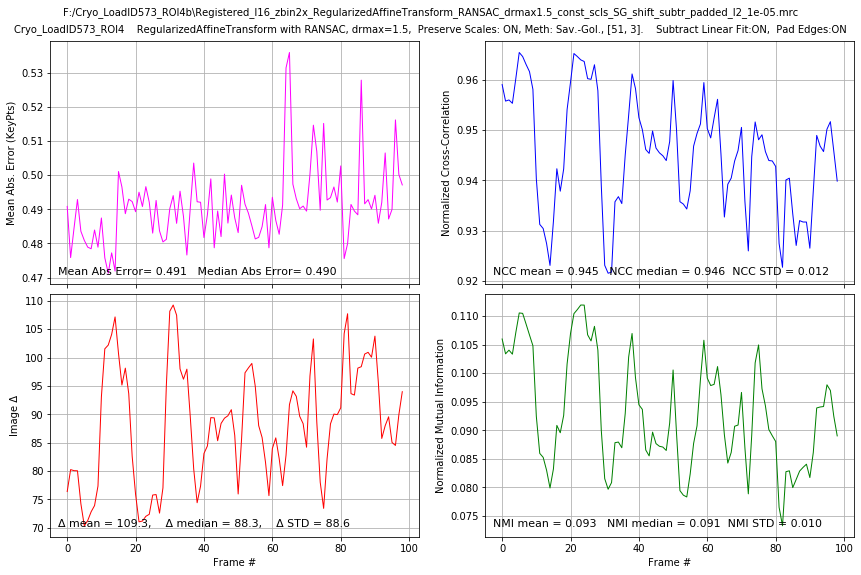

In [14]:
%%time

dformat_save = 'I8' if mrc_mode==0 else 'I16'
    
test_frame = FIBSEM_frame(os.path.join(data_dir,fls[0]))
    
if pad_edges:
    '''
    Xshift_residual = tr_matr_cum_residual[:, 0, 2]
    Yshift_residual = tr_matr_cum_residual[:, 1, 2]
    padx = np.int16(np.max(Xshift_residual) - np.min(Xshift_residual))
    pady = np.int16(np.max(Yshift_residual) - np.min(Yshift_residual))
    xi = np.int16(np.max([np.max(Xshift_residual), 0]))
    yi = np.int16(np.max([np.max(Yshift_residual), 0]))
    '''
    shape = [test_frame.YResolution, test_frame.XResolution]
    xmn, xmx, ymn, ymx = determine_pad_offsets(shape, tr_matr_cum_residual)
    padx = np.int16(xmx - xmn)
    pady = np.int16(ymx - ymn)
    xi = np.int16(np.max([xmx, 0]))
    yi = np.int16(np.max([ymx, 0]))
    # The initial transformation matrices are calculated with no padding.Padding is done prior to transformation
    # so that the transformed images are not clipped.
    # Such padding means shift (by xi and yi values). Therefore the new transformation matrix
    # for padded frames will be (Shift Matrix)x(Transformation Matrix)x(Inverse Shift Matrix)
    # those are calculated below base on the amount of padding calculated above
    shift_matrix = np.array([[1.0, 0.0, xi],
                             [0.0, 1.0, yi],
                             [0.0, 0.0, 1.0]])
    inv_shift_matrix = numpy.linalg.inv(shift_matrix)
else:
    padx = 0
    pady = 0
    xi = 0
    yi = 0
    shift_matrix = np.eye(3,3)
    inv_shift_matrix = np.eye(3,3)

'''
padx1 = padx + 1
pady1 = pady + 1
      
# test to determine whether the shifts (xi, yi) or inverse shifts (-xi,-yi) should be used
xi=1500
padx=3000
yi=1000
pady=2000
shift_matrix = np.array([[1.0, 0.0, xi],
                             [0.0, 1.0, yi],
                             [0.0, 0.0, 1.0]])
inv_shift_matrix = numpy.linalg.inv(shift_matrix)
shift_matrix = np.eye(3,3)
inv_shift_matrix = np.eye(3,3)
''' 

fpath_reg = os.path.join(data_dir, fnm_reg)
xsz = test_frame.XResolution + padx
xa = xi + test_frame.XResolution
ysz = test_frame.YResolution + pady
ya = yi + test_frame.YResolution

frame0_img = np.zeros((ysz, xsz))
frame1_img = frame0_img.copy()
frame_img = frame0_img.copy()
prev_frame_img = frame0_img.copy()

image_diff = np.zeros((len(fls)-1), dtype=float)
image_ncc = np.zeros((len(fls)-1), dtype=float)
image_mi = np.zeros((len(fls)-1), dtype=float) 

if zbin_2x:
    # Execute this frame if 2x z-binning is selected
    print('Saving the registered and 2x z-binned stack into the file: ', fpath_reg)
    # Make a new, empty memory-mapped MRC file
    mrc = mrcfile.new_mmap(fpath_reg, shape=(len(fls)//2, ysz, xsz), mrc_mode=mrc_mode, overwrite=True)
    # mode 0 -> int8
    # mode 1 -> int16:
    mrc.voxel_size = np.round(test_frame.PixelSize)*0.001
    ind = np.arange(0,len(fls)-1,2)
    for j in tqdm(ind, desc = 'Saving into ' + dformat_save + ' MRC File'):
        frame0_img[yi:ya, xi:xa]  = FIBSEM_frame(os.path.join(data_dir,fls[j])).RawImageA
        transf0 = ProjectiveTransform(matrix = shift_matrix @ (tr_matr_cum_residual[j] @ inv_shift_matrix))
        frame0_img_reg = warp(frame0_img, transf0, order = int_order,  preserve_range=True)
        frame1_img[yi:ya, xi:xa]  = FIBSEM_frame(os.path.join(data_dir,fls[j+1])).RawImageA
        transf1 = ProjectiveTransform(matrix = shift_matrix @ (tr_matr_cum_residual[j+1] @ inv_shift_matrix))
        frame1_img_reg = warp(frame1_img, transf1, order = int_order, preserve_range=True)
        if (mrc_mode==0 and test_frame.EightBit==0):
            curr_img = np.clip((((frame0_img_reg - data_min_glob) + (frame1_img_reg - data_min_glob))/(data_max_glob - data_min_glob)/2.0*255.0), 0, 255)
        else:
            curr_img = frame0_img_reg/2.0 + frame1_img_reg/2.0
        mrc.data[j//2,:,:] = np.flip(curr_img.astype(dtp), axis=0)
        I1c = cp.array(frame0_img_reg.astype(float)[yi:ya, xi:xa])
        if j>0:
            I2c = cp.array(prev_frame_img[yi:ya, xi:xa])
            image_diff[j-1] =  cp.asnumpy(cp.mean(cp.abs(I1c-I2c)))
            image_ncc[j-1] = correlation_coefficient(frame0_img_reg.astype(float)[yi:ya, xi:xa], prev_frame_img[yi:ya, xi:xa])
            image_mi[j-1] = cp.asnumpy(mutual_information_2d_cp(I1c.ravel(), I2c.ravel(), sigma=1.0, bin=2048, normalized=True))
        I2c = cp.array(frame1_img_reg.astype(float)[yi:ya, xi:xa])
        image_diff[j] =  cp.asnumpy(cp.mean(cp.abs(I1c-I2c)))
        image_ncc[j] = correlation_coefficient(frame0_img_reg.astype(float)[yi:ya, xi:xa], frame1_img_reg.astype(float)[yi:ya, xi:xa])
        image_mi[j] = cp.asnumpy(mutual_information_2d_cp(I1c.ravel(), I2c.ravel(), sigma=1.0, bin=2048, normalized=True))
        prev_frame_img = frame1_img_reg.astype(float)
        del I1c, I2c
else:
    # Execute this frame if 2x z-binning is NOT selected
    print('Saving the registered stack into the file: ', fpath_reg)
    # Make a new, empty memory-mapped MRC file
    mrc = mrcfile.new_mmap(fpath_reg, shape=(len(fls), ysz, xsz), mrc_mode=mrc_mode, overwrite=True)
    # mode 0 -> int8
    # mode 1 -> int16:
    mrc.voxel_size = np.round(test_frame.PixelSize)*0.001
    ind = np.arange(0,len(fls))
    for j, fl in enumerate(tqdm(fls, desc = 'Saving into ' + dformat_save + ' MRC File')):
        frame_img[yi:ya, xi:xa]  = FIBSEM_frame(os.path.join(data_dir,fl)).RawImageA
        transf = ProjectiveTransform(matrix = shift_matrix @ (tr_matr_cum_residual[j] @ inv_shift_matrix))
        frame_img_reg = warp(frame_img, transf, order = int_order, preserve_range=True)
        if (mrc_mode==0 and test_frame.EightBit==0):
            curr_img = np.clip(((frame_img_reg - data_min_glob)/(data_max_glob - data_min_glob)*255.0), 0, 255)
        else:
            curr_img = frame_img_reg
        mrc.data[j,:,:] = np.flip(curr_img.astype(dtp), axis=0)
        if j>0:
            I1c = cp.array(frame_img_reg.astype(float)[yi:ya, xi:xa])
            I2c = cp.array(prev_frame_img[yi:ya, xi:xa])
            image_diff[j-1] =  cp.asnumpy(cp.mean(cp.abs(I1c-I2c)))
            image_ncc[j-1] = correlation_coefficient(prev_frame_img[yi:ya, xi:xa], frame_img_reg.astype(float)[yi:ya, xi:xa])
            image_mi[j-1] = cp.asnumpy(mutual_information_2d_cp(I1c.ravel(), I2c.ravel(), sigma=1.0, bin=2048, normalized=True))
            del I1c, I2c
        prev_frame_img = frame_img_reg.astype(float)
mrc.close()
        
# Generate a figure with analysis of registration quality - Image Delta's vs. frames.
#image_diff = image_diff[1:-1]
imd = [np.max(image_diff), np.mean(image_diff), np.median(image_diff), np.std(image_diff)] 
#image_ncc = image_ncc[1:-1]
nccs = [np.mean(image_ncc), np.median(image_ncc), np.std(image_ncc)]
nmi = [np.mean(image_mi), np.median(image_mi), np.std(image_mi)]

Pres_scales = 'ON' if  preserve_scales else 'OFF'
Subtr_Lin_Fit = 'ON' if  subtract_linear_fit else 'OFF'
Pad_Edg = 'ON' if  pad_edges else 'OFF'

fs=12
lwl=1
if preserve_scales:
    fit_method = fit_params[0]
    if fit_method == 'LF':
        fit_str = ', Meth: Linear Fit'
        fm_string = 'linear'
    else:
        if fit_method == 'SG':
            fit_str = ', Meth: Sav.-Gol., ' + str(fit_params[1:])
            fm_string = 'Sav.-Gol.'
        else:
            fit_str = ', Meth: ' + fit_method + ', ' + str(fit_params[1:])
            fm_string = fit_method
    preserve_scales_string = 'Preserve Scales: ON' + fit_str
else:
    preserve_scales_string = 'Preserve Scales: OFF'
    
cond_str = SIFT_Transform.__name__ + ' with ' + solver + ', drmax={:.1f},  '.format(drmax) + preserve_scales_string + '.    Subtract Linear Fit:' + Subtr_Lin_Fit + ',  Pad Edges:'+Pad_Edg

fig4, axs4 = subplots(2,2, figsize=(12, 8), sharex=True)
fig4.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.92, wspace=0.18, hspace=0.04)

axs4[0,0].plot(error_abs_mean, 'magenta', linewidth=lwl)
#axs4[0,0].text(0.02, 0.12, cond_str, transform=axs4[0,0].transAxes)
axs4[0,0].text(0.02, 0.04, 'Mean Abs Error= {:.3f}   Median Abs Error= {:.3f}'.format(np.mean(error_abs_mean), np.median(error_abs_mean)), transform=axs4[0,0].transAxes, fontsize = fs-1)
axs4[0,0].set_ylabel('Mean Abs. Error (KeyPts)')

axs4[1,0].plot(image_diff, 'r', linewidth=lwl)
axs4[1,0].set_ylabel('Image Δ')
#axs4[1,0].text(0.02, 0.12, cond_str, transform=axs4[0,1].transAxes)
axs4[1,0].text(0.02, 0.04, 'Δ mean = {:.1f},    Δ median = {:.1f},    Δ STD = {:.1f}'.format(imd[0], imd[1], imd[2]), transform=axs4[1,0].transAxes, fontsize = fs-1)
axs4[1,0].set_xlabel('Frame #')

axs4[0,1].plot(image_ncc, 'b', linewidth=lwl)
axs4[0,1].set_ylabel('Normalized Cross-Correlation')
axs4[0,1].grid(True)
#axs4[0,1].legend(loc='upper left')
#axs4[0,1].text(0.02, 0.12, cond_str, transform=axs4[1,0].transAxes)
axs4[0,1].text(0.02, 0.04, 'NCC mean = {:.3f}   NCC median = {:.3f}  NCC STD = {:.3f}'.format(nccs[0], nccs[1], nccs[2]), transform=axs4[0,1].transAxes, fontsize = fs-1)

axs4[1,1].plot(image_mi, 'g', linewidth=lwl)
axs4[1,1].set_ylabel('Normalized Mutual Information')
axs4[1,1].set_xlabel('Frame #')
axs4[1,1].grid(True)
#axs4[1,1].legend(loc='upper left')
#axs4[1,1].text(0.02, 0.12, cond_str, transform=axs4[1,1].transAxes)
axs4[1,1].text(0.02, 0.04, 'NMI mean = {:.3f}   NMI median = {:.3f}  NMI STD = {:.3f}'.format(nmi[0], nmi[1], nmi[2]), transform=axs4[1,1].transAxes, fontsize = fs-1)

for ax in axs4.ravel():
    ax.grid(True)
    #ax.legend(loc='upper left')

     
fig4.suptitle(os.path.join(data_dir, fnm_reg), fontsize = fs-2)
axs4[0,0].text(-0.1, 1.04, Sample_ID + '    ' +  cond_str, transform=axs4[0,0].transAxes)
fig4.savefig(os.path.join(data_dir, fnm_reg.replace('.mrc','_RegistrationQuality.png')), dpi=300)

print('Delta Image Results for: ', SIFT_Transform.__name__ , ', ',solver,'',
      ', preserve_scales=', preserve_scales, ', subtract_linear_fit=', subtract_linear_fit, ', pad_edges=', pad_edges)
print('Δmin={:.1f},  Δmax={:.1f},  Δmean={:.1f},  Δmed={:.1f}'.format(imd[0], imd[1], imd[2], imd[3]))
print('')

registration_summary_fnm = os.path.join(data_dir, fnm_reg).replace('.mrc', '_RegistrationQuality.csv')
columns=['Npts', 'Mean Abs Error', 'Image Delta', 'Image NCC', 'Image MI']
reg_summary = pd.DataFrame(np.vstack((npts, error_abs_mean, image_diff, image_ncc, image_mi)).T, columns = columns, index = None)
reg_summary.to_csv(registration_summary_fnm, index = None)

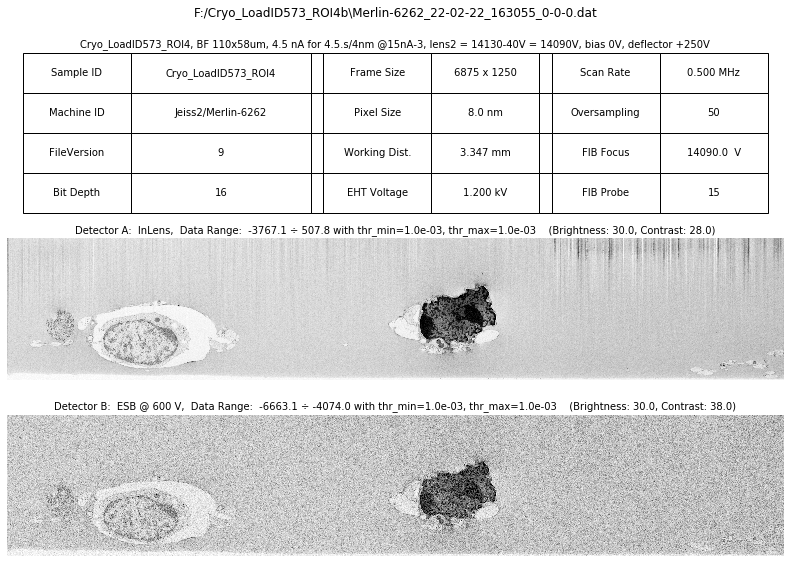

In [4]:
frame_img = FIBSEM_frame(os.path.join(data_dir,fls[50]))
frame_img.save_images()
frame_img.save_snapshot(dpi=300)